In [1]:
import os
import numpy as np
from nilearn import plotting, image, input_data, maskers
from nilearn.image import resample_to_img, concat_imgs
from nilearn.input_data import NiftiMasker
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from nilearn.plotting import view_img
import nibabel as nib

/Users/yanw4/.local/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
# Automatically list all .nii and .nii.gz files under /PET folder
pet_folder = '/Users/yanw4/Documents/LNI_P1_MP_DFNC_202212/data/PET/nnc/logan_ref/'
pet_images = [os.path.join(pet_folder, f) for f in os.listdir(pet_folder) if (f.endswith('.nii') or f.endswith('.nii.gz')) and f.startswith('Harmonized')]
pet_images.sort()

In [3]:
# Vector of ages corresponding to the subjects
dwell_time_fpn_plus = np.array([0.420750000000000,-2.327082353,1.620771429,0.259875,0.522605769,	0,2.7324,2.512218045,-0.12239011,1.03275,2.685375,1.370769231,-1.55925,2.1384,	-0.22275,1.976793522,-1.782,1.62,1.447875,-0.004895604,	0.537428571,1.896557143,1.188,0.729,0.540964286,-0.3601125,-0.616846154,-0.984016484,-0.794475,4.0392,	0.81675,-1.701635294,1.7982,2.074757143,1.998,3.1878,0.0891 ])  # Make sure this is in the same order as pet_images
dwell_time_vis_minus = np.array([-1.50727500000000,0.489789473684211,-0.615599999999999,2.27991176470588,0.247500000000000,0.567000000000000,0.507184615384615,-0.675000000000000,2.33030769230769,-0.102807692307692,-0.594000000000000,1.02446963562753,1.31528571428571,0.648000000000001,-0.447784615384616,0.356400000000001,-0.193923529411764,1.47150000000000,-0.148499999999999,-0.0185624999999998,2.55420000000000,2.70669327731092,2.49480000000000,3.68280000000000,1.50975000000000,1.35135000000000,0.763714285714285,-0.445500000000000,-0.438750000000000,-0.811038461538461,0.483685714285714,2.12355000000000,2.05354285714286,2.15325000000000,2.09727692307692,0.618750000000000,0.0989999999999993])
fractional_occ_fpn_plus = np.array([0.0306553749904631,0.00417332731332901,0.0412645157336765,-0.0429395028451632,0.0379269188018588,-0.0183973084569506,0.140883323088296,0.0368003591739000,0.00268771983483712,0.0147607589444203,0.0546524686652075,0.0382503334815474,-0.0438413361169102,0.0403294822421909,-0.0223358350697966,-0.0188830720745614,0.00542986425339365,-0.0398667575138163,-0.0298491075069800,0.0141292293324513,0.0761718750000000,0.0732177263969172,0.00183084678792833,0.00483248225183709,0.0306112778392039,-0.0181409610215054,-0.0153609831029186,-0.0389127495426708,-0.0174947620472912,0.0726376049201253,0.0484400474284867,-0.0398727023495555,0.0978091057878292,0.0167497396220801,0.0376062992125984,0.0721144024514811,0.0282400806605638	])
fractional_occ_som_plus = np.array([-0.0351186388952468,-0.0767225144093684,-0.0567454116493550,-0.0120919436957173,-0.0275295208173544,-0.00735204159657441,-0.0765565425610986,-0.0123091888656091,-0.0467808533414895,-0.0423099680485977,0.0834173573027076,-0.0889691714836224,-0.0313152400835073,-0.0257809157038939,0.0555191871507865,-0.0422544677863827,-0.0717020536025061,-0.00264213793625559,0.0364526147378988,-0.112520186003074,-0.00976562500000000,-0.0635838150289017,-0.00876251788268956,-0.0617137875202391,-0.0581385247196335,-0.0283014112903226,-0.0749167946748592,-0.0677125586574405,-0.00604609398383715,0.0558155726608131,-0.00154142581888247,0.0463057227829126,-0.201774289540247,-0.117069632495164,-0.102015748031496,-0.0125297923050732,0.187180478011557])
fractional_occ_vis_minus = np.array([-0.0660639353017472,0.105683616232860,-0.0560713300854858,0.00247079964061098,0.0206061252363511,0.0181411530815109,-0.0320488869068425,-0.00894941634241245,0.0623298669521334,0.0523135182044101,-0.115780931067555,0.0959278197717504,0.102296450939457,0.00144415917843388,-0.0675468845082889,0.0427921704517449,0.0637080867850099,0.0461579226285109,-0.0362016500925432,0.0635951514679845,-0.0410156250000000,0.0520231213872832,0.0471421758975407,0.0545356416324158,0.0539132838414153,0.0598496303763441,0.0134408602150538,0.0525172989739919,-0.00313528883567794,-0.0916450702046184,0.0386505113383726,0.0245937778062799,0.152964588602887,0.0784444279125130,0.0982519685039370,0.0761548064918851,-0.0787328829489076])

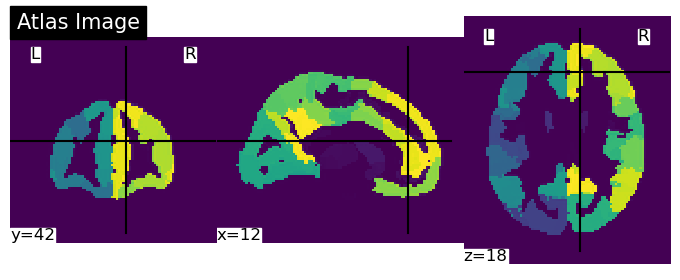

In [4]:
# Load the atlas and only keep regions labeled 1 to 32
atlas_img = image.load_img('/Users/yanw4/Documents/LNI_P1_MP_DFNC_202212/rSchaefer2018_200Parcels_7Networks_order_Tian_Subcortex_S2_3T_MNI152NLin2009cAsym_2mm.nii')
atlas_data = atlas_img.get_fdata()

# Display the atlas image
plotting.plot_img(atlas_img, title='Atlas Image')
plotting.show()

In [5]:
# Get image information
header = atlas_img.header
affine = atlas_img.affine
shape = atlas_data.shape
resolution = header.get_zooms()

# Display image information
print("Atlas Image Information:")
print(f"Resolution: {resolution}")
print(f"Dimension: {shape}")
print(f"Affine:\n{affine}")

print(header['descrip'])

Atlas Image Information:
Resolution: (1.9999999, 2.0, 2.0)
Dimension: (91, 109, 91)
Affine:
[[-1.99999952e+00  1.11275911e-03 -4.70876694e-04  8.99437103e+01]
 [ 1.11252069e-03  1.99999952e+00  8.72254372e-04 -1.26075226e+02]
 [-4.71353531e-04 -8.72015953e-04  1.99999976e+00 -7.19223862e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
b'spm - realigned'


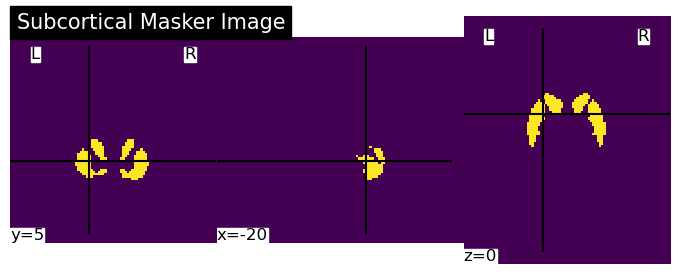

In [6]:
mask_data = np.isin(atlas_data, np.array([9, 10, 13, 14, 15, 16, 25, 26, 29, 30, 31, 32]))
mask_img = image.new_img_like(atlas_img, mask_data)
mask_img
plotting.plot_img(mask_img, title='Subcortical Masker Image')
plotting.show()

In [7]:
masker = NiftiMasker(mask_img=mask_img, standardize=True)

In [8]:
# Load images
# Load and resample PET images to the atlas image space
resampled_pet_imgs = [resample_to_img(nib.load(img_path), atlas_img) for img_path in pet_images]
pet_imgs = image.concat_imgs(resampled_pet_imgs)
pet_data = pet_imgs.get_fdata()

In [9]:
np.shape(pet_data)

(91, 109, 91, 37)

In [10]:
pet_data_2d = masker.fit_transform(pet_imgs)

In [11]:
np.shape(pet_data_2d)

(37, 3337)

fractional_occ_fpn+


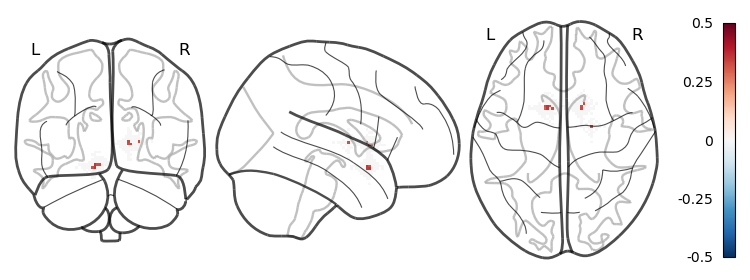

In [12]:
correlation_coefficients = np.zeros(pet_data_2d.shape[1])
p_values = np.zeros(pet_data_2d.shape[1])
# Perform Pearson correlation for each voxel
for i in range(pet_data_2d.shape[1]):
    correlation_coefficients[i], p_values[i] = pearsonr(pet_data_2d[:, i], fractional_occ_fpn_plus)
# Threshold coefficients by p-value
significant_correlation = np.where(p_values < 0.05, correlation_coefficients, 0)
# Convert the significant correlation values back into a Nifti image
correlation_img = masker.inverse_transform(significant_correlation)
print('fractional_occ_fpn+')
plotting.plot_glass_brain(correlation_img, colorbar=True, cmap='RdBu_r', plot_abs=False, symmetric_cbar=True,vmax=0.5, vmin=-0.5)

corrcted fractional_occ_fpn+


/Users/yanw4/.local/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


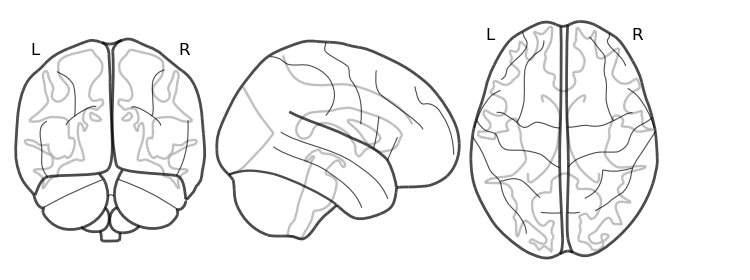

In [13]:
# Apply FDR correction
from statsmodels.stats.multitest import multipletests
_, corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
# Threshold coefficients by corrected p-value
significant_correlation = np.where(corrected_p_values < 0.05, correlation_coefficients, 0)
# Convert the significant correlation values back into a Nifti image
correlation_img = masker.inverse_transform(significant_correlation)
print('corrcted fractional_occ_fpn+')
plotting.plot_glass_brain(correlation_img, colorbar=True, cmap='RdBu_r', plot_abs=False, symmetric_cbar=True,vmax=0.5, vmin=-0.5)

fractional_occ_som+


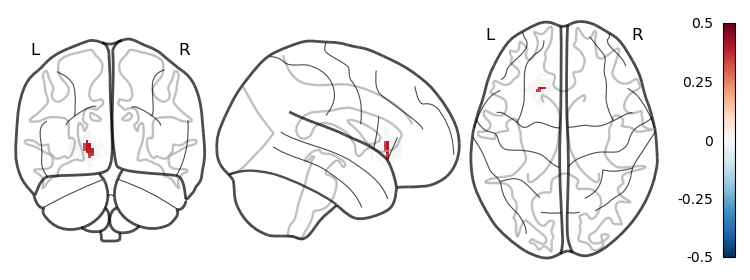

In [14]:
correlation_coefficients = np.zeros(pet_data_2d.shape[1])
p_values = np.zeros(pet_data_2d.shape[1])
# Perform Pearson correlation for each voxel
for i in range(pet_data_2d.shape[1]):
    correlation_coefficients[i], p_values[i] = pearsonr(pet_data_2d[:, i], fractional_occ_som_plus)
# Threshold coefficients by p-value
significant_correlation = np.where(p_values < 0.05, correlation_coefficients, 0)
# Convert the significant correlation values back into a Nifti image
correlation_img = masker.inverse_transform(significant_correlation)
print('fractional_occ_som+')
plotting.plot_glass_brain(correlation_img, colorbar=True, cmap='RdBu_r', plot_abs=False, symmetric_cbar=True,vmax=0.5, vmin=-0.5)

corrcted fractional_occ_som+


/Users/yanw4/.local/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


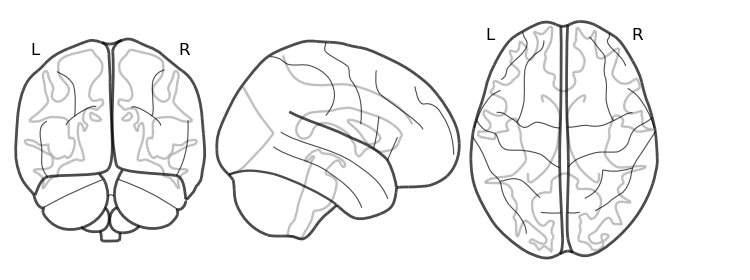

In [15]:
# Apply FDR correction
from statsmodels.stats.multitest import multipletests
_, corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
# Threshold coefficients by corrected p-value
significant_correlation = np.where(corrected_p_values < 0.05, correlation_coefficients, 0)
# Convert the significant correlation values back into a Nifti image
correlation_img = masker.inverse_transform(significant_correlation)
print('corrcted fractional_occ_som+')
plotting.plot_glass_brain(correlation_img, colorbar=True, cmap='RdBu_r', plot_abs=False, symmetric_cbar=True,vmax=0.5, vmin=-0.5)

fractional_occ_vis-


/Users/yanw4/.local/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


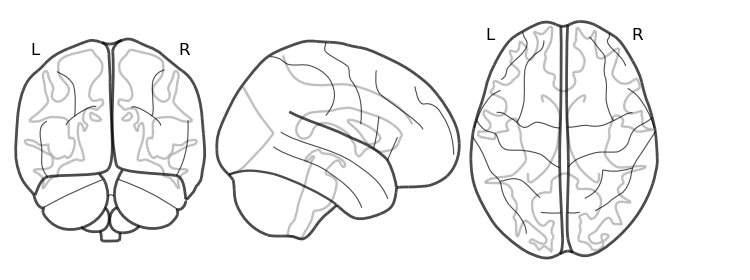

In [16]:
correlation_coefficients = np.zeros(pet_data_2d.shape[1])
p_values = np.zeros(pet_data_2d.shape[1])
# Perform Pearson correlation for each voxel
for i in range(pet_data_2d.shape[1]):
    correlation_coefficients[i], p_values[i] = pearsonr(pet_data_2d[:, i], fractional_occ_vis_minus)
# Threshold coefficients by p-value
significant_correlation = np.where(p_values < 0.05, correlation_coefficients, 0)
# Convert the significant correlation values back into a Nifti image
correlation_img = masker.inverse_transform(significant_correlation)
print('fractional_occ_vis-')
plotting.plot_glass_brain(correlation_img, colorbar=True, cmap='RdBu_r', plot_abs=False, symmetric_cbar=True,vmax=0.5, vmin=-0.5)

corrcted fractional_occ_vis-


/Users/yanw4/.local/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


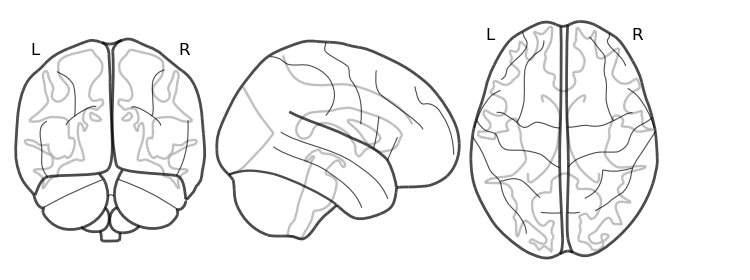

In [17]:
# Apply FDR correction
from statsmodels.stats.multitest import multipletests
_, corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
# Threshold coefficients by corrected p-value
significant_correlation = np.where(corrected_p_values < 0.05, correlation_coefficients, 0)
# Convert the significant correlation values back into a Nifti image
correlation_img = masker.inverse_transform(significant_correlation)
print('corrcted fractional_occ_vis-')
plotting.plot_glass_brain(correlation_img, colorbar=True, cmap='RdBu_r', plot_abs=False, symmetric_cbar=True,vmax=0.5, vmin=-0.5)

dwell_time_fpn+


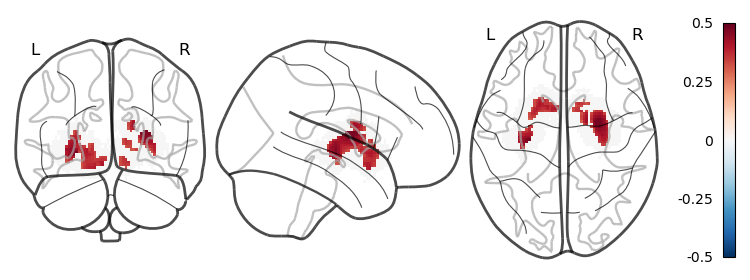

In [18]:
correlation_coefficients = np.zeros(pet_data_2d.shape[1])
p_values = np.zeros(pet_data_2d.shape[1])
# Perform Pearson correlation for each voxel
for i in range(pet_data_2d.shape[1]):
    correlation_coefficients[i], p_values[i] = pearsonr(pet_data_2d[:, i], dwell_time_fpn_plus)
# Threshold coefficients by p-value
significant_correlation = np.where(p_values < 0.05, correlation_coefficients, 0)
# Convert the significant correlation values back into a Nifti image
correlation_img = masker.inverse_transform(significant_correlation)
print('dwell_time_fpn+')
plotting.plot_glass_brain(correlation_img, colorbar=True, cmap='RdBu_r', plot_abs=False, symmetric_cbar=True,vmax=0.5, vmin=-0.5)

dwell_time_vis_minus - Permutation Test


/Users/yanw4/.local/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


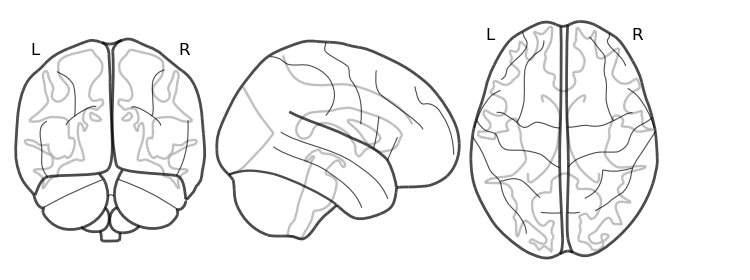

In [19]:
from nilearn.mass_univariate import permuted_ols
# Assuming `pet_data_2d` is your 2D PET data matrix and `dwell_time_vis_minus` is your variable of interest
# Also assuming `masker` is your masker object for transforming data

# Reshape data for permuted_ols
y = pet_data_2d  # shape (n_samples,n_voxels)
X = dwell_time_vis_minus[:, np.newaxis]  # shape (n_samples, 1)

# Perform permutation test
neg_log_pvals, t_scores_original_data, _ = permuted_ols(X, y, n_perm=10000)

# Set a threshold for significance (e.g., negative log of p < 0.05)
threshold = -np.log10(0.05)

# Apply the threshold
significant_voxels = np.where(neg_log_pvals > threshold, neg_log_pvals, 0)

# Convert the significant voxels back into a Nifti image
significant_img = masker.inverse_transform(significant_voxels)

# Plot the significant correlations
print('dwell_time_vis_minus - Permutation Test')
plotting.plot_glass_brain(significant_img, colorbar=True, cmap='RdBu_r', plot_abs=False, symmetric_cbar=True)

corrcted dwell_time_fpn+


/Users/yanw4/.local/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


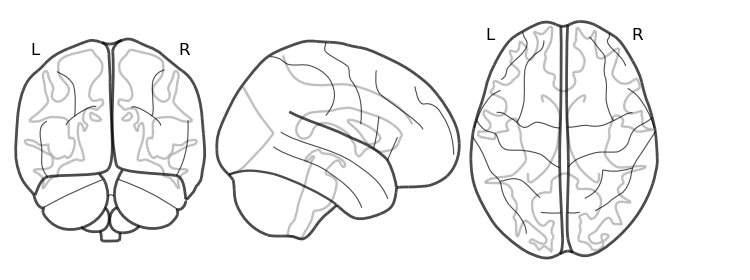

In [20]:
# Apply FDR correction
from statsmodels.stats.multitest import multipletests
_, corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
# Threshold coefficients by corrected p-value
significant_correlation = np.where(corrected_p_values < 0.05, correlation_coefficients, 0)
# Convert the significant correlation values back into a Nifti image
correlation_img = masker.inverse_transform(significant_correlation)
print('corrcted dwell_time_fpn+')
plotting.plot_glass_brain(correlation_img, colorbar=True, cmap='RdBu_r', plot_abs=False, symmetric_cbar=True,vmax=0.5, vmin=-0.5)

dwell_time_vis-


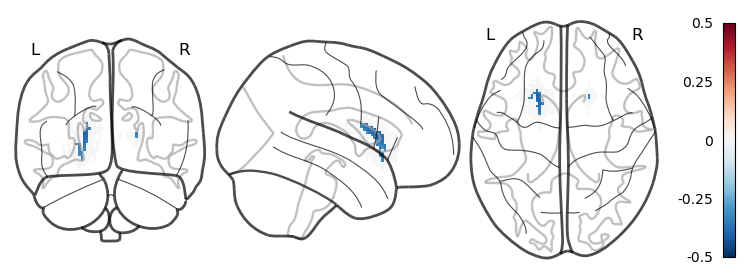

In [21]:
correlation_coefficients = np.zeros(pet_data_2d.shape[1])
p_values = np.zeros(pet_data_2d.shape[1])
# Perform Pearson correlation for each voxel
for i in range(pet_data_2d.shape[1]):
    correlation_coefficients[i], p_values[i] = pearsonr(pet_data_2d[:, i], dwell_time_vis_minus)
# Threshold coefficients by p-value
significant_correlation = np.where(p_values < 0.05, correlation_coefficients, 0)
# Convert the significant correlation values back into a Nifti image
correlation_img = masker.inverse_transform(significant_correlation)
print('dwell_time_vis-')
plotting.plot_glass_brain(correlation_img, colorbar=True, cmap='RdBu_r', plot_abs=False, symmetric_cbar=True,vmax=0.5, vmin=-0.5)

corrcted dwell_time_vis-


/Users/yanw4/.local/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


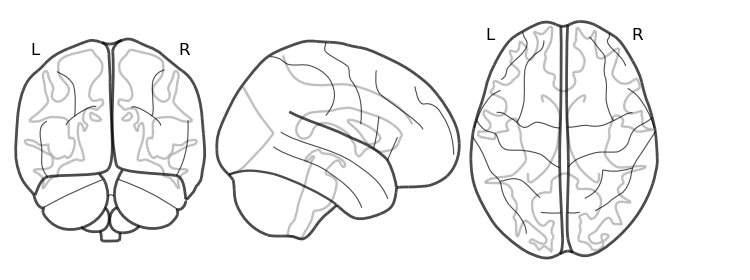

In [22]:
# Apply FDR correction
from statsmodels.stats.multitest import multipletests
_, corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
# Threshold coefficients by corrected p-value
significant_correlation = np.where(corrected_p_values < 0.05, correlation_coefficients, 0)
# Convert the significant correlation values back into a Nifti image
correlation_img = masker.inverse_transform(significant_correlation)
print('corrcted dwell_time_vis-')
plotting.plot_glass_brain(correlation_img, colorbar=True, cmap='RdBu_r', plot_abs=False, symmetric_cbar=True,vmax=0.5, vmin=-0.5)